<a href="https://colab.research.google.com/github/jrakhshanda/Bayesian-Methods/blob/master/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyLDAvis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import wordnet

import regex as re
from nltk.stem.porter import PorterStemmer 
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import pickle
import os
from os.path import isfile, join

#for vectorizing
nltk.download('stopwords')
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

import gensim.corpora as corpora
from pprint import pprint
import gensim

import spacy

import pyLDAvis.gensim
import pickle 
import pyLDAvis

#comment this out if you're not able to view any of the print lines
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/data/data.zip', compression='zip', header=0)
df = df.loc[:,~df.columns.str.match("Unnamed")]
df.head()

,PMID,Title,Abstract
0,33581499,"PCNA, a focus on replication stress and the al...","The maintenance of telomeres, which are specia..."
1,33581339,Compositional Variability and Mutation Spectra...,COVID-19 and its causative pathogen SARS-CoV-2...
2,33580188,Histone variant H2A.B-H2B dimers are spontaneo...,H2A.B is an evolutionarily distant histone H2A...
3,33580181,Hypermutated phenotype in gliosarcoma of the s...,Gliosarcoma is a variant of glioblastoma with ...
4,33580144,Arsenic hexoxide has differential effects on c...,Arsenic is reportedly a biphasic inorganic com...


In [5]:
df['Text'] = df['Title'] + '. ' + df['Abstract']
df['Text'] = df['Text'].astype('str')

# Reuseable Routiens

In [6]:
def save_object(path, filename, obj):
    print('Saving Object')
    path_file = join(path, filename)    
    pickle.dump(obj, open(path_file, 'wb'))
    print('Save complete')

def load_object(path, filename):
    print('Attempting to Load Object')
    path_file = join(path, filename)    
    obj = pickle.load(open(path_file, "rb" ))
    print('Load complete')
    return obj

def save_csv(path, filename, dataframe):
    print('Saving Dataframe to CSV')
    path_file = join(path, filename)    
    dataframe.to_csv(path_file, index=False)

def load_csv(path, filename):
    print('Loading Dataframe From CSV')
    path_file = join(path, filename)
    dataframe = pd.read_csv(path_file)
    return dataframe

# Pre-processing

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['type','wild','function','observed','results','different','identified','from','furthermore','process','model','effect','known','suggest','damage','human','rat','rats',
                'suggested','conclusion','determined','indicate','Moreover','system', 'form', 'treatment','disease','although','conclusion','including','exposure','repair','injury','cell',
                'functions','compared','interaction','level','demonstrated','studies','substrate','interaction','shown','contrast','presence','important', 'response','cells', 'effect','risk',
                'induction', 'increase', 'also', 'breaks','treated','showed','used','comet', 'affect', 'may', 'two','study','gene','end','ends','let','double','single','strands','stress',
                'pathway','role','demonstrate','present','result','use','occur','appear','joining','affect','cause','induce','defect','induced','lead','complex','resistance','calls','ber',
                'analyzed','include','similar','studied','method','addition','suggesting','background','gene','expression','investigated','promote','types','dna','proteins','protein', 'ner',
                'high','low','agents','using','strands','cycle','drug','investigate','increased','that','induce','structure','bindings','binding','molecular','mouse','mice','activity',
                'levels','level','patient','patients','dose','drug','recombination','yeast','strand','mutants','mutations','replications','homologous','genetic','genes','associative','lung',
                'specific','light','molecular','binding','sequence','lines','cancer','poly','inhibitation','activation','nuclear','regulation','tumor','mismatch','excision','base',
                'cellular','growth','irridation','tumors','mutations','transription','resistance','site','adducts','dose','enzyme','associated','analysis','species','tissue',
                'factor','domain','clinical','cancers','liver','assay','irradiated','irradiation','nucleotide','one','damage','increase','resist','mechanism','association','group','groups','aging']
stopwords.extend(newStopWords)

In [11]:
def preprocess(text):
  text = stemmer.stem(text) 
  tokenizer = RegexpTokenizer(r'\w+')
  words_tokens = tokenizer.tokenize(text) 
  tokens = []  
  for w in words_tokens:  
    if w not in stopwords:  
      tokens.append(w)  
  tokens = [x for x in tokens if len(x) >= 3]
  return tokens

In [30]:
tokens = [preprocess(i) for i in df['Text']]

In [13]:
#save_object('/content/drive/MyDrive/models','topic_tokens',tokens)
tokens = load_object('/content/drive/MyDrive/models','topic_tokens')

Attempting to Load Object
Load complete


# LDA model Training

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(tokens)
# Create Corpus
texts = tokens
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 5), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [ ]:
# number of topics
num_topics = 8
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


In [16]:
pprint(lda_model.print_topics())

[(0,
  '0.007*"genome" + 0.006*"chromosome" + 0.004*"dsb" + 0.004*"sequences" + '
  '0.003*"chromosomal" + 0.003*"mutant" + 0.003*"break" + 0.003*"genomic" + '
  '0.003*"plasmid" + 0.003*"dependent"'),
 (1,
  '0.009*"mutation" + 0.004*"radiation" + 0.004*"lesions" + '
  '0.004*"mutagenesis" + 0.004*"frequency" + 0.003*"mutagenic" + '
  '0.003*"strains" + 0.003*"mutant" + 0.003*"synthesis" + 0.003*"however"'),
 (2,
  '0.010*"radiation" + 0.006*"effects" + 0.005*"apoptosis" + 0.004*"p53" + '
  '0.004*"gamma" + 0.004*"inhibition" + 0.003*"vitro" + 0.003*"cisplatin" + '
  '0.003*"normal" + 0.003*"survival"'),
 (3,
  '0.014*"p53" + 0.007*"mgmt" + 0.005*"transcription" + 0.005*"kinase" + '
  '0.005*"replication" + 0.005*"dependent" + 0.004*"mitochondrial" + '
  '0.004*"promoter" + 0.004*"atm" + 0.004*"apoptosis"'),
 (4,
  '0.012*"parp" + 0.009*"adp" + 0.008*"polymerase" + 0.007*"ercc1" + '
  '0.007*"ribose" + 0.006*"beta" + 0.006*"inhibitors" + 0.005*"therapy" + '
  '0.005*"platinum" + 0.004

## Analysis of Results

### What is the Dominant topic and its percentage contribution in each document?
In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [48]:
def format_topics_sentences(ldamodel=None, corpus = corpus, texts= texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


In [49]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['PMID', 'Dominant Topic', 'Topic % Contribution', 'Keywords', 'Text']
df_dominant_topic['PMID'] = df['PMID']
df_dominant_topic.head(8)

In [34]:
#save_csv('/content/drive/MyDrive/data','dominant_topics',df_dominant_topic)
#df_dominant_topic = load_csv('/content/drive/MyDrive/data','dominant_topics')
pd.options.display.max_colwidth = 100
df_dominant = df_dominant_topic.copy()

### Frequency Distribution of Word Counts in Documents

When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

<Figure size 1296x576 with 0 Axes>

(array([  2.,   0.,   0.,   1.,   5.,   3.,   3.,   8.,   4.,   8.,   7.,
          6.,   9.,  10.,  15.,   9.,  16.,  14.,  20.,  20.,  22.,  22.,
         28.,  36.,  41.,  44.,  45.,  37.,  48.,  56.,  53.,  59.,  49.,
         70.,  77.,  71.,  79.,  77.,  80.,  78.,  98.,  96.,  94.,  90.,
        131., 121., 131., 141., 137., 139., 140., 181., 181., 170., 185.,
        172., 176., 222., 208., 232., 269., 262., 274., 304., 286., 289.,
        321., 325., 379., 335., 369., 384., 400., 405., 396., 394., 463.,
        483., 498., 466., 481., 504., 522., 561., 576., 574., 642., 611.,
        633., 625., 614., 668., 693., 647., 647., 681., 704., 762., 777.,
        824., 859., 849., 822., 868., 774., 838., 912., 853., 849., 916.,
        950., 873., 916., 823., 943., 983., 983., 978., 954., 925., 955.,
        938., 948., 877., 927., 966., 986., 922., 927., 911., 888., 846.,
        821., 907., 895., 953., 970., 903., 891., 880., 876., 928., 848.,
        839., 850., 866., 841., 832., 

Text(2000, 900, 'Mean   : 1200')

Text(2000, 850, 'Median : 1177')

Text(2000, 800, 'Stdev   : 401')

Text(2000, 750, '1% quantile    : 369')

Text(2000, 700, '99% quantile  : 2323')

[Text(0, 0.5, 'Number of Documents'),
 (0.0, 2500.0),
 Text(0.5, 0, 'Document Word Count')]

([<matplotlib.axis.XTick at 0x7fd65e439da0>,
 <a list of 9 Text major ticklabel objects>)

Text(0.5, 1.0, 'Distribution of Document Word Counts')

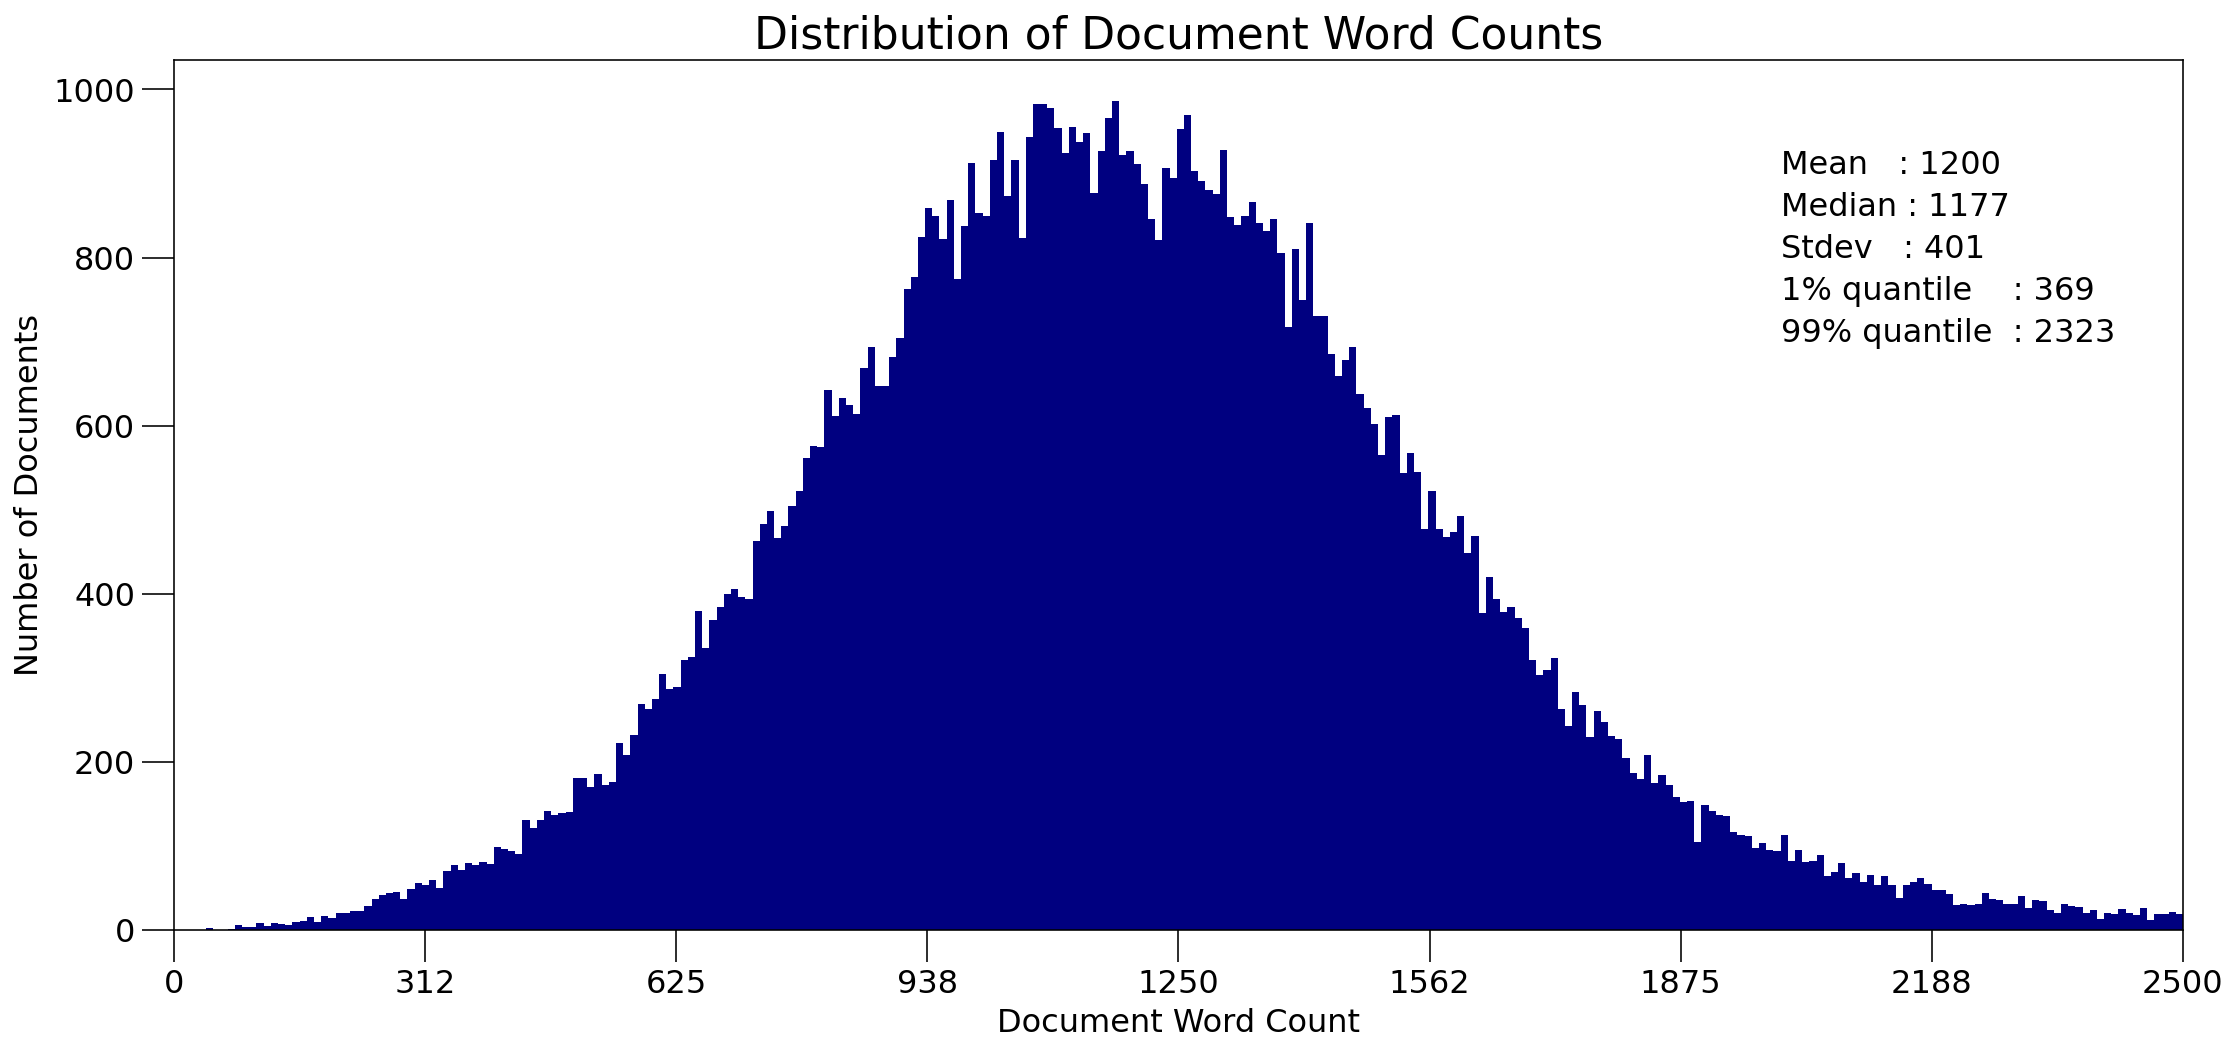

In [56]:
doc_lens = [len(d) for d in df_dominant.Text]

# Plot
plt.figure(figsize=(18,8))
plt.rcParams.update({'font.size': 16})
# plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(2000, 900, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(2000,  850, "Median : " + str(round(np.median(doc_lens))))
plt.text(2000,  800, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(2000,  750, "1% quantile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(2000,  700, "99% quantile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 2500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,2500,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.savefig('/content/drive/MyDrive/plots/distribution_word_counts.png')

<Figure size 432x288 with 0 Axes>

### Visualize The topics

In [45]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '/content/drive/MyDrive/models'+ str(num_topics) +'.html')
LDAvis_prepared

FileNotFoundError: ignored